Figures in the paper correspond to 10 temperatures reconstructions. Here it is for one reconstruction only. Data are avaible on the Zenodo archive https://zenodo.org/uploads/14046994.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from sklearn.metrics import confusion_matrix
import math
import os
import seaborn as sns
from matplotlib import rc

In [4]:
my_colormap=sns.color_palette("Spectral", as_cmap=True).reversed()

In [5]:
membre='r5i1p1f1'
#(find data on the Zenodo archive https://zenodo.org/uploads/14046994)
data_psl = xr.open_dataset('/UNET-vs-Analogues_data/psl_day_MIROC6_unet_'+str(membre)+'_CR.nc') # normalized sea level pressure 
Ttarget_r5 = xr.open_dataset('/UNET-vs-Analogues_data/anomalies_r5.nc').tasano[25550:25550+26645] # temperature anomalies 

In [6]:
lon = Ttarget_r5.lon
lat = Ttarget_r5.lat

In [7]:
#grid cell located near Toulouse
id_lat = 11
id_lon = 9

In [8]:
#MODEL
model ='model_40members_input3286' 

In [9]:
#Load DAILY series (target and reconstructed by the analogues and UNET) available on the Zenodo archive

Trec_r5_analogues = np.load('/UNET-vs-Analogues_data/Trec_r5i1p1f1.npy') #Temperature predicted by the analogues of member r1i1p1f1
Trec_r5_unet = np.load('/UNET-vs-Analogues_data/Tpred_unet_r5.npy').reshape(26645,32,32)[:-1] #Teemperature predicted by the UNET of member r1i1p1f1
Ttarget_r5 = xr.open_dataset('/UNET-vs-Analogues_data/anomalies_r5.nc').tasano[25550:25550+26644] #True temperature of member r1i1p1f1


In [10]:
#Calculate RMSE
def rmse(s1,s2):
    diff_carre = (np.array(s1)-np.array(s2))**2
    error = round(np.sqrt(np.sum(diff_carre)/len(diff_carre)),2)
    return(error)

## DAILY SERIES

### UNET

In [19]:
#We randomly choose one year (2019) to plot temperature variations
annee_target = Ttarget_r5[365*69:365*70,id_lat,id_lon]
annee_unet = Trec_r5_unet[365*69:365*70,id_lat,id_lon]
annee_analogues = Trec_r5_analogues[365*69:365*70,id_lat,id_lon] 

(array([-8., -6., -4., -2.,  0.,  2.,  4.,  6.,  8.]),
 [Text(0, -8.0, '$\\mathdefault{−8}$'),
  Text(0, -6.0, '$\\mathdefault{−6}$'),
  Text(0, -4.0, '$\\mathdefault{−4}$'),
  Text(0, -2.0, '$\\mathdefault{−2}$'),
  Text(0, 0.0, '$\\mathdefault{0}$'),
  Text(0, 2.0, '$\\mathdefault{2}$'),
  Text(0, 4.0, '$\\mathdefault{4}$'),
  Text(0, 6.0, '$\\mathdefault{6}$'),
  Text(0, 8.0, '$\\mathdefault{8}$')])

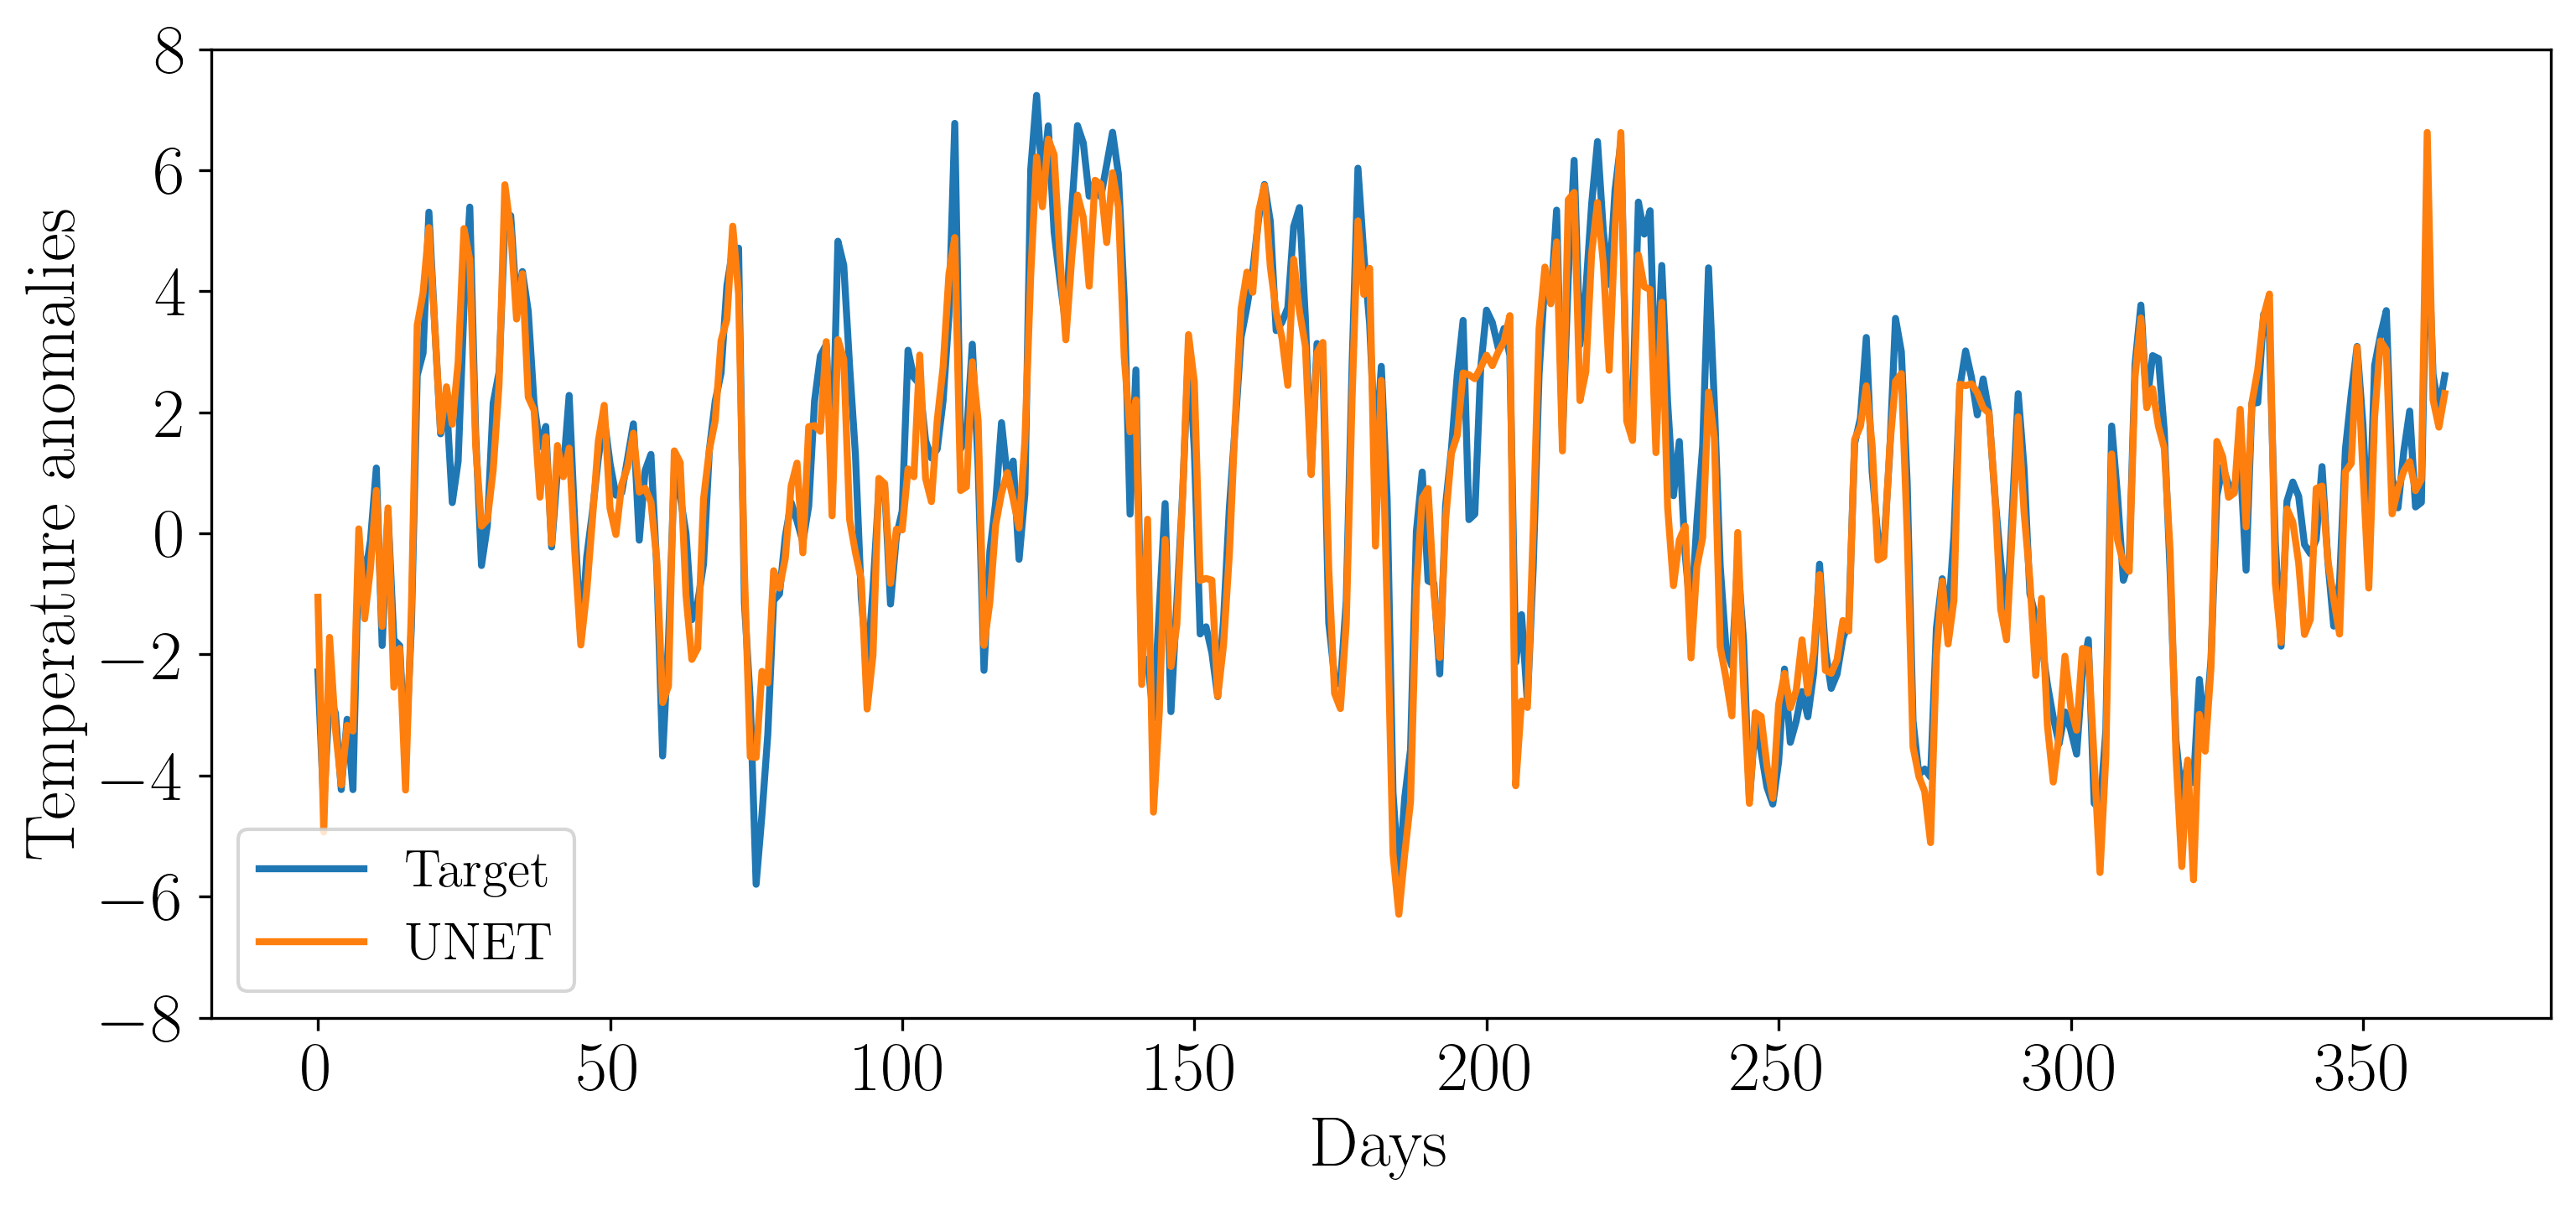

In [20]:
plt.figure(figsize=(12,5))
plt.plot(annee_target,label='Target',color='tab:blue',linewidth=2)
plt.plot(annee_unet,label=f'UNET',color='tab:orange',linewidth=2)
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
positions =[0,31,59,90,120,151,181,212,243,273,304,334]
plt.ylim(-8,8)
plt.xlabel('Days', fontsize=20)
plt.ylabel('Temperature anomalies', fontsize=20)
plt.legend(fontsize=15,loc='lower left')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [17]:
#SCORES ON DAILY SERIES 
#we calculate for each grid point the rmse, correlation and variance ratio

rmse_day_unet = [[0 for i in range(32)] for j in range(32)] # map of RMSE
corr_day_unet = [[0 for i in range(32)] for j in range(32)] # map of correlation
v_day_unet = [[0 for i in range(32)] for j in range(32)] # map of variance ratio

for i in range(32):
    for j in range(32):
        rmse_day_unet[i][j]=rmse(Ttarget_r5[:,i,j],Trec_r5_unet[:,i,j])
        corr_day_unet[i][j]=np.corrcoef(Ttarget_r5[:,i,j],Trec_r5_unet[:,i,j])[0,1]
        v_day_unet[i][j]=float(np.var(Trec_r5_unet[:,i,j]))/float(np.var(Ttarget_r5[:,i,j]))

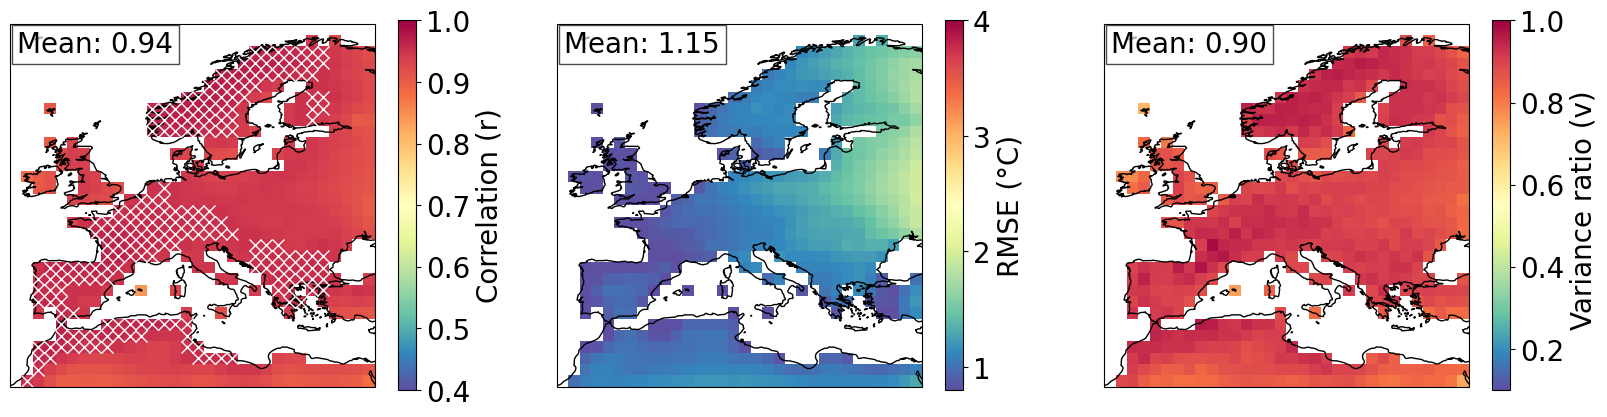

In [21]:
masque = xr.open_dataset('/UNET-vs-Analogues_data/mask.nc').tab

# only plot land values
masked_corr = np.ma.masked_where(masque == 1, corr_day_unet)
masked_rmse = np.ma.masked_where(masque == 1, rmse_day_unet)
masked_var = np.ma.masked_where(masque == 1, v_day_unet)

# Code original avec les valeurs sur la mer masquées
fig, axs = plt.subplots(1, 3, figsize=(20, 12), subplot_kw={'projection': ccrs.PlateCarree()})

# First map (correlation)
cf1 = axs[0].pcolormesh(lon, lat, masked_corr, vmin=0.40,vmax=1,cmap=my_colormap, transform=ccrs.PlateCarree())
axs[0].coastlines()
# axs[0].set_title('Cor/rélation moyenne')  
axs[0].text(0.02, 0.98, f'Mean: {masked_corr.mean():.2f}', transform=axs[0].transAxes,
            fontsize=20, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))

for i in range(len(lon)):
    for j in range(len(lat)):
        if masked_corr[j, i]>0.9499:
            axs[0].plot(lon[i], lat[j], marker='x', color='white', markersize=8, transform=ccrs.PlateCarree())


# Second map (RMSE)
cf2 = axs[1].pcolormesh(lon, lat, masked_rmse,vmin=0.8,vmax=4,cmap=my_colormap, transform=ccrs.PlateCarree())
axs[1].coastlines()
axs[1].text(0.02, 0.98, f'Mean: {masked_rmse.mean():.2f}', transform=axs[1].transAxes,
            fontsize=20, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))

# Third map (variance ratio)
cf3 = axs[2].pcolormesh(lon, lat, masked_var,vmin=0.1,vmax=1, cmap=my_colormap, transform=ccrs.PlateCarree())
axs[2].coastlines()
axs[2].text(0.02, 0.98, f'Mean: {masked_var.mean():.2f}', transform=axs[2].transAxes,
            fontsize=20, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))

cb1 = fig.colorbar(cf1, ax=axs[0], orientation='vertical', aspect=20, shrink=0.4)
cb2 = fig.colorbar(cf2, ax=axs[1], orientation='vertical', aspect=20, shrink=0.4)
cb3 = fig.colorbar(cf3, ax=axs[2], orientation='vertical', aspect=20, shrink=0.4)

cb1.ax.tick_params(labelsize=20)
cb2.ax.tick_params(labelsize=20)
cb3.ax.tick_params(labelsize=20)

cb1.set_label('Correlation (r)', fontsize=20)
cb2.set_label('RMSE (°C)', fontsize=20)
cb3.set_label('Variance ratio (v) ', fontsize=20)

plt.show()


### Analogues

In [22]:
#SCORES ON DAILY SERIES 

rmse_day_ana = [[0 for i in range(32)] for j in range(32)]
corr_day_ana = [[0 for i in range(32)] for j in range(32)]
v_day_ana = [[0 for i in range(32)] for j in range(32)]

for i in range(32):
    for j in range(32):
        rmse_day_ana[i][j]=rmse(Ttarget_r5[:,i,j],Trec_r5_analogues[:,i,j])
        corr_day_ana[i][j]=np.corrcoef(Ttarget_r5[:,i,j],Trec_r5_analogues[:,i,j])[0,1]
        v_day_ana[i][j]=float(np.var(Trec_r5_analogues[:,i,j]))/float(np.var(Ttarget_r5[:,i,j]))

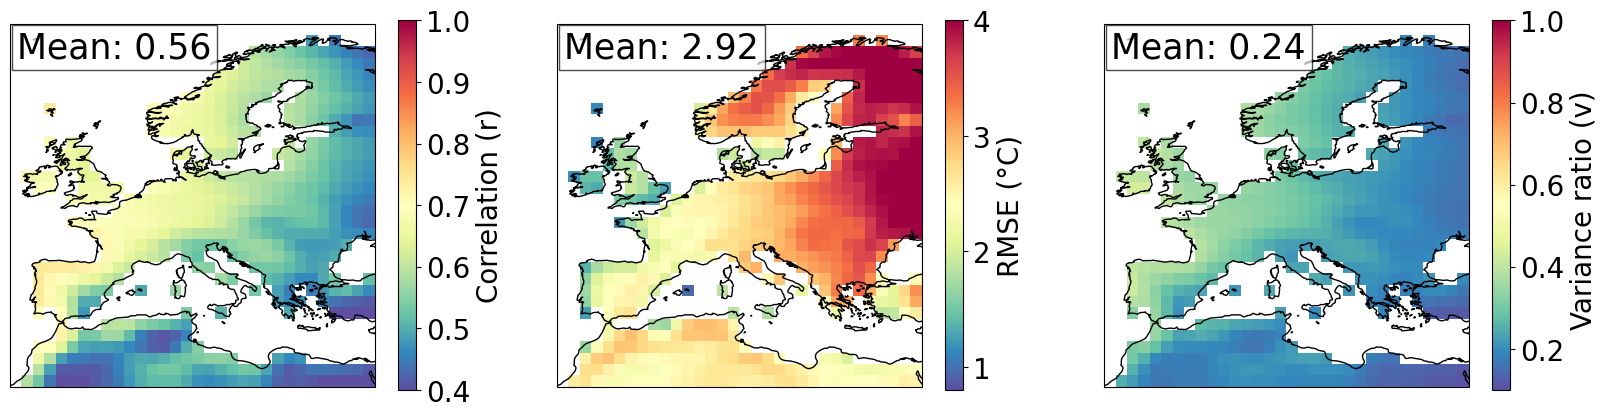

In [23]:
#only plot land values
masked_corr = np.ma.masked_where(masque == 1, corr_day_ana)
masked_rmse = np.ma.masked_where(masque == 1, rmse_day_ana)
masked_var = np.ma.masked_where(masque == 1, v_day_ana)

fig, axs = plt.subplots(1,3, figsize=(20, 12), subplot_kw={'projection': ccrs.PlateCarree()})

# First map (correlation)
cf1 = axs[0].pcolormesh(lon, lat, masked_corr,vmin=0.4,vmax=1,cmap=my_colormap, transform=ccrs.PlateCarree())
axs[0].coastlines()
axs[0].text(0.02, 0.98, f'Mean: {masked_corr.mean():.2f}', transform=axs[0].transAxes,
            fontsize=25, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))

# Second map (RMSE)
cf2 = axs[1].pcolormesh(lon, lat, masked_rmse, vmin=0.8,vmax=4,cmap=my_colormap, transform=ccrs.PlateCarree())
axs[1].coastlines()
axs[1].text(0.02, 0.98, f'Mean: {masked_rmse.mean():.2f}', transform=axs[1].transAxes,
            fontsize=25, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))

# Third map (variance ratio)
cf3 = axs[2].pcolormesh(lon, lat, masked_var, vmin=0.1,vmax=1,cmap=my_colormap, transform=ccrs.PlateCarree())
axs[2].coastlines()
axs[2].text(0.02, 0.98, f'Mean: {masked_var.mean():.2f}', transform=axs[2].transAxes,
            fontsize=25, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))
            
cb1 = fig.colorbar(cf1, ax=axs[0], orientation='vertical', aspect=20, shrink=0.4)
cb2 = fig.colorbar(cf2, ax=axs[1], orientation='vertical', aspect=20, shrink=0.4)
cb3 = fig.colorbar(cf3, ax=axs[2], orientation='vertical', aspect=20, shrink=0.4)

cb1.ax.tick_params(labelsize=20)
cb2.ax.tick_params(labelsize=20)
cb3.ax.tick_params(labelsize=20)

cb1.set_label('Correlation (r)', fontsize=20)
cb2.set_label('RMSE (°C)', fontsize=20)
cb3.set_label('Variance ratio (v) ', fontsize=20)

plt.show()


(array([-8., -6., -4., -2.,  0.,  2.,  4.,  6.,  8.]),
 [Text(0, -8.0, '−8'),
  Text(0, -6.0, '−6'),
  Text(0, -4.0, '−4'),
  Text(0, -2.0, '−2'),
  Text(0, 0.0, '0'),
  Text(0, 2.0, '2'),
  Text(0, 4.0, '4'),
  Text(0, 6.0, '6'),
  Text(0, 8.0, '8')])

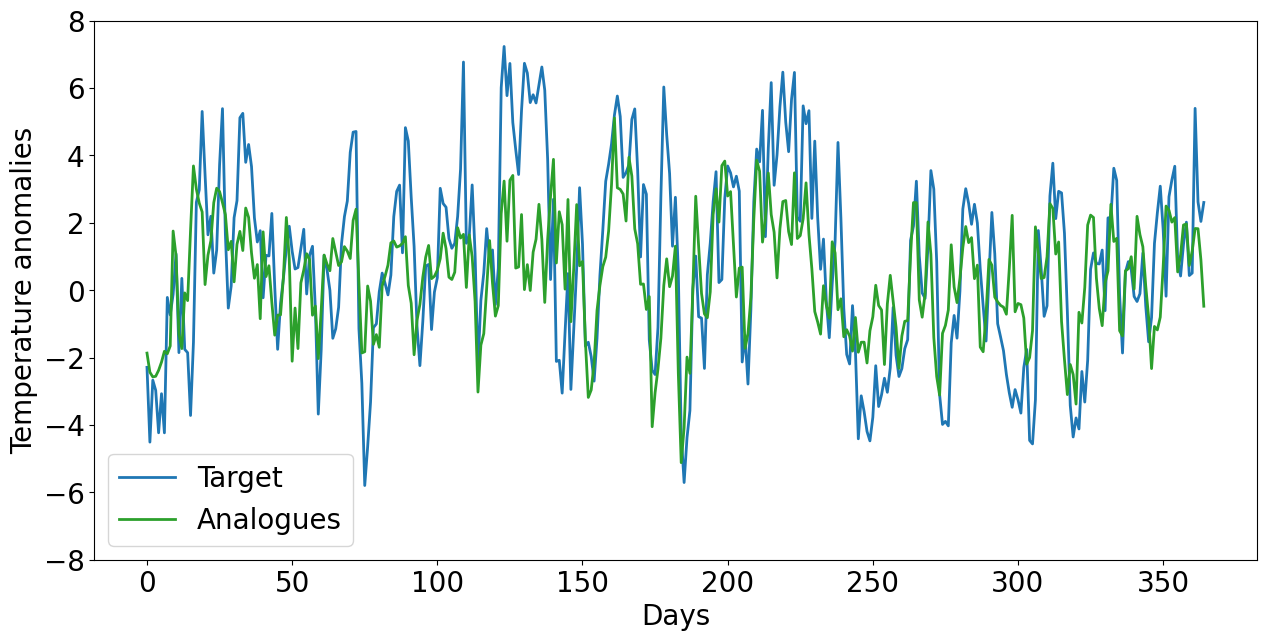

In [28]:
plt.figure(figsize=(15,7))
plt.plot(annee_target,label='Target',color='tab:blue',linewidth=2)
plt.plot(annee_analogues,label=f'Analogues',color='tab:green',linewidth=2)
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
positions =[0,31,59,90,120,151,181,212,243,273,304,334]
plt.ylim(-8,8)
plt.xlabel('Days', fontsize=20)
plt.ylabel('Temperature anomalies', fontsize=20)
plt.legend(fontsize=20,loc='lower left')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

(array([-8., -6., -4., -2.,  0.,  2.,  4.,  6.,  8.]),
 [Text(0, -8.0, '−8'),
  Text(0, -6.0, '−6'),
  Text(0, -4.0, '−4'),
  Text(0, -2.0, '−2'),
  Text(0, 0.0, '0'),
  Text(0, 2.0, '2'),
  Text(0, 4.0, '4'),
  Text(0, 6.0, '6'),
  Text(0, 8.0, '8')])

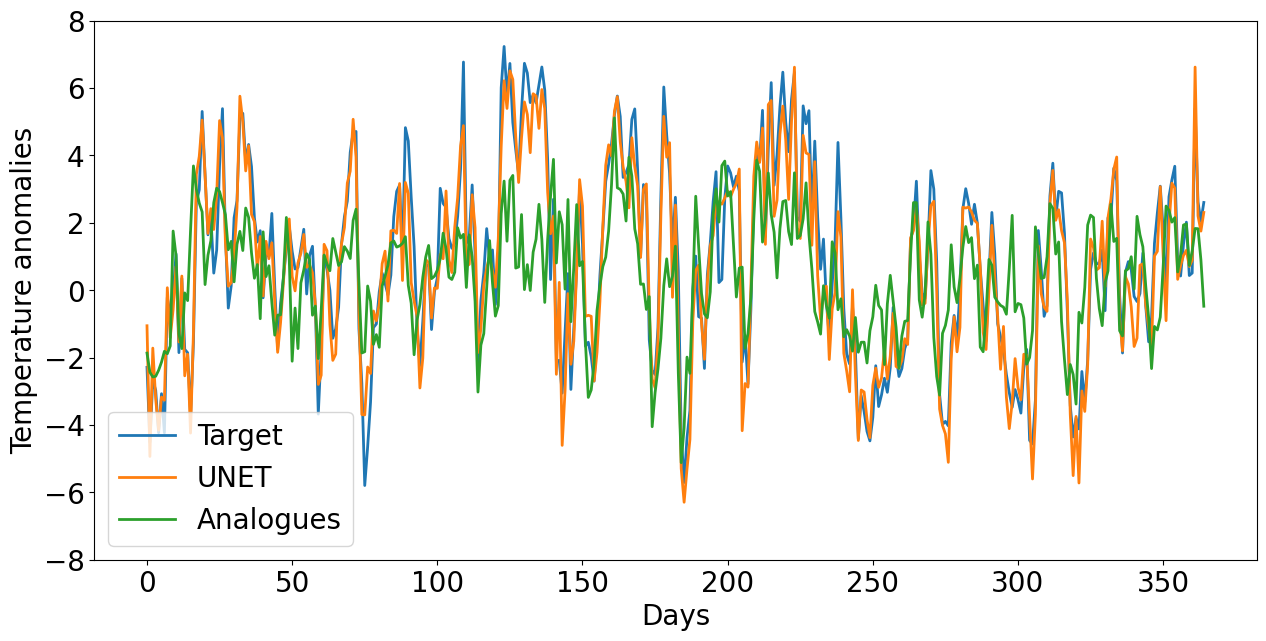

In [29]:
plt.figure(figsize=(15,7))
plt.plot(annee_target,label='Target',color='tab:blue',linewidth=2)
plt.plot(annee_unet,label=f'UNET',color='tab:orange',linewidth=2)
plt.plot(annee_analogues,label=f'Analogues',color='tab:green',linewidth=2)
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
positions =[0,31,59,90,120,151,181,212,243,273,304,334]
plt.ylim(-8,8)
plt.xlabel('Days', fontsize=20)
plt.ylabel('Temperature anomalies', fontsize=20)
plt.legend(fontsize=20,loc='lower left')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

## Yearly mean of daily series

In [30]:
# calculate yearly mean (31th of december 2022 is missing)

def yearly_mean(data):
    annual_means=[]
    for i in range(72): 
        start_day = i * 365
        end_day = start_day + 365
        annual_mean = np.mean(data[start_day:end_day, :, :], axis=0)
        annual_means.append(annual_mean)
    
    start_day = (72) * 365
    annual_mean_last_year = np.mean(data[start_day:, :, :], axis=0)
    annual_means.append(annual_mean_last_year)
    
    annual_means = np.array(annual_means)
    
    return(annual_means)

In [31]:
Ttarget_year = np.array(Ttarget_r5.resample(time='YS-JAN').mean('time'))
Trec_analogues_year = np.array(yearly_mean(Trec_r5_analogues))
Trec_unet_year = np.array(yearly_mean(Trec_r5_unet))

### UNET

(array([-1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5]),
 [Text(0, -1.5, '−1.5'),
  Text(0, -1.0, '−1.0'),
  Text(0, -0.5, '−0.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.5, '1.5')])

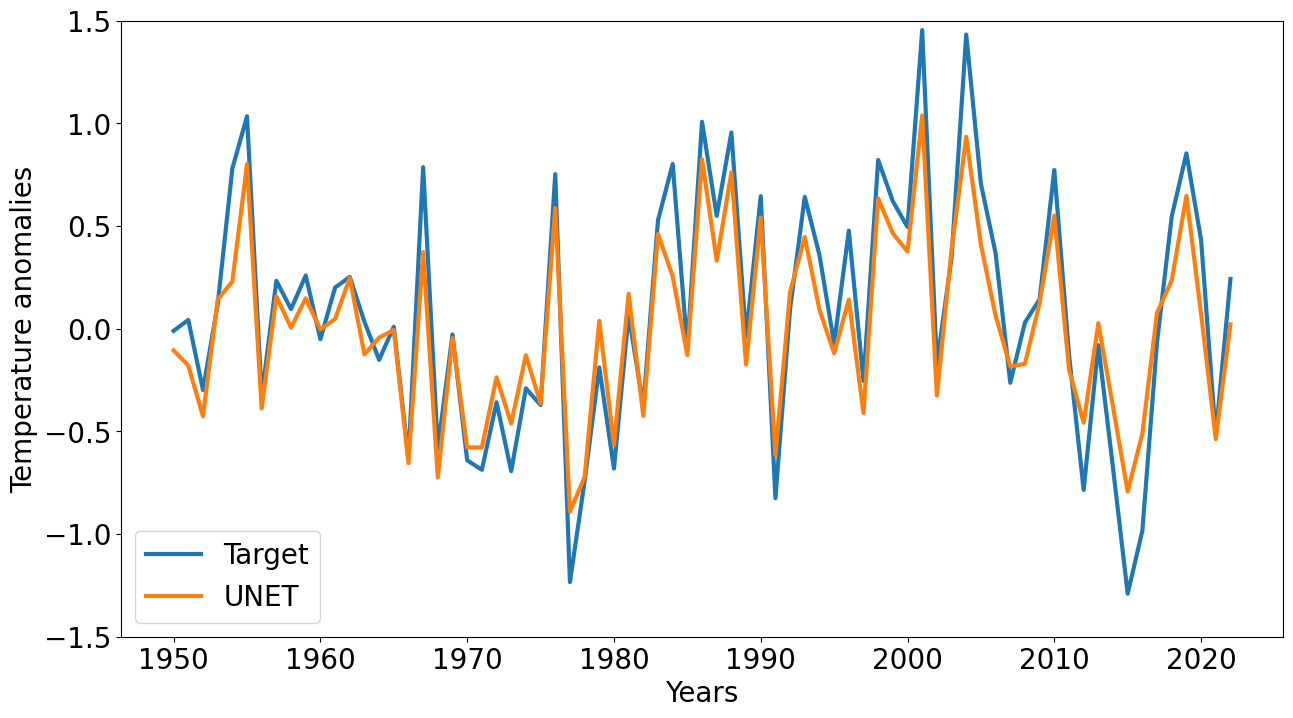

In [32]:
years = [i for i in range(1950, 2023)]
plt.figure(figsize=(15,8))
plt.plot(years,Ttarget_year[:,id_lat,id_lon],label='Target',linewidth=3)
plt.plot(years,Trec_unet_year[:,id_lat,id_lon],label=f'UNET',color='tab:orange',linewidth=3)# - r={round(np.corrcoef(ymean_cible_r5_1point,ymean_rec_r5_unet_1point)[0][1],2)} - RMSE={str(rmse(ymean_cible_r5_1point,ymean_rec_r5_unet_1point))}°C',color='tab:orange')
plt.xlabel('Years', fontsize=20)
plt.ylabel('Temperature anomalies', fontsize=20)
plt.ylim(-1.5,1.5)
plt.legend(fontsize=20,loc='lower left')
plt.xticks(fontsize=20)  
plt.yticks(fontsize=20)

In [33]:
rmse_year_unet = [[0 for i in range(32)] for j in range(32)]
corr_year_unet = [[0 for i in range(32)] for j in range(32)]
v_year_unet = [[0 for i in range(32)] for j in range(32)]

for i in range(32):
    for j in range(32):
        rmse_year_unet[i][j]=rmse(Ttarget_year[:,i,j],Trec_unet_year[:,i,j])
        corr_year_unet[i][j]=np.corrcoef(Ttarget_year[:,i,j],Trec_unet_year[:,i,j])[0,1]
        v_year_unet[i][j]=float(np.var(Trec_unet_year[:,i,j]))/float(np.var(Ttarget_year[:,i,j]))

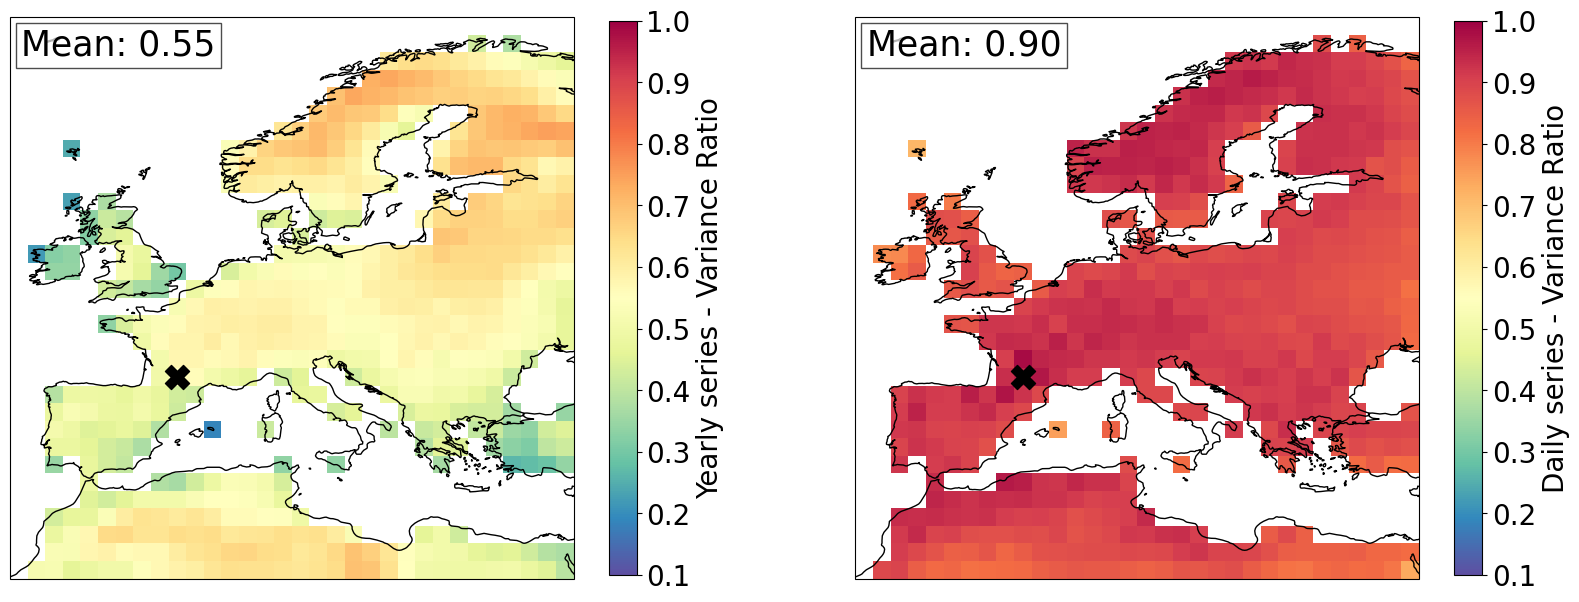

In [35]:
#VARIANCES

masque = xr.open_dataset('/UNET-vs-Analogues_data/mask.nc').tab

# Masquer les valeurs sur la mer
masked_v_year = np.ma.masked_where(masque == 1, v_year_unet)
masked_v_day = np.ma.masked_where(masque == 1, v_day_unet)

# Code original avec les valeurs sur la mer masquées
fig, axs = plt.subplots(1, 2, figsize=(20, 12), subplot_kw={'projection': ccrs.PlateCarree()})

# Première carte
cf1 = axs[0].pcolormesh(lon, lat, masked_v_year,vmin=0.1,vmax=1,cmap=my_colormap, transform=ccrs.PlateCarree(0))
axs[0].coastlines()
axs[0].scatter(1.406,44.12, color='black', marker='X', s=300)
axs[0].text(0.02, 0.98, f'Mean: {masked_v_year.mean():.2f}', transform=axs[0].transAxes,
            fontsize=25, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))


# Deuxième carte
cf2 = axs[1].pcolormesh(lon, lat, masked_v_day,vmin=0.1,vmax=1, cmap=my_colormap, transform=ccrs.PlateCarree())
axs[1].coastlines()
axs[1].scatter(1.406,44.12, color='black', marker='X', s=300)
axs[1].text(0.02, 0.98, f'Mean: {masked_v_day.mean():.2f}', transform=axs[1].transAxes,
            fontsize=25, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))

cb1 = fig.colorbar(cf1, ax=axs[0], orientation='vertical', aspect=20, shrink=0.6)
cb2 = fig.colorbar(cf2, ax=axs[1], orientation='vertical', aspect=20, shrink=0.6)

cb1.ax.tick_params(labelsize=20)
cb2.ax.tick_params(labelsize=20)

cb1.set_label('Yearly series - Variance Ratio', fontsize=20)
cb2.set_label('Daily series - Variance Ratio', fontsize=20)

plt.show()


### Analogues

(array([-1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5]),
 [Text(0, -1.5, '−1.5'),
  Text(0, -1.0, '−1.0'),
  Text(0, -0.5, '−0.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.5, '1.5')])

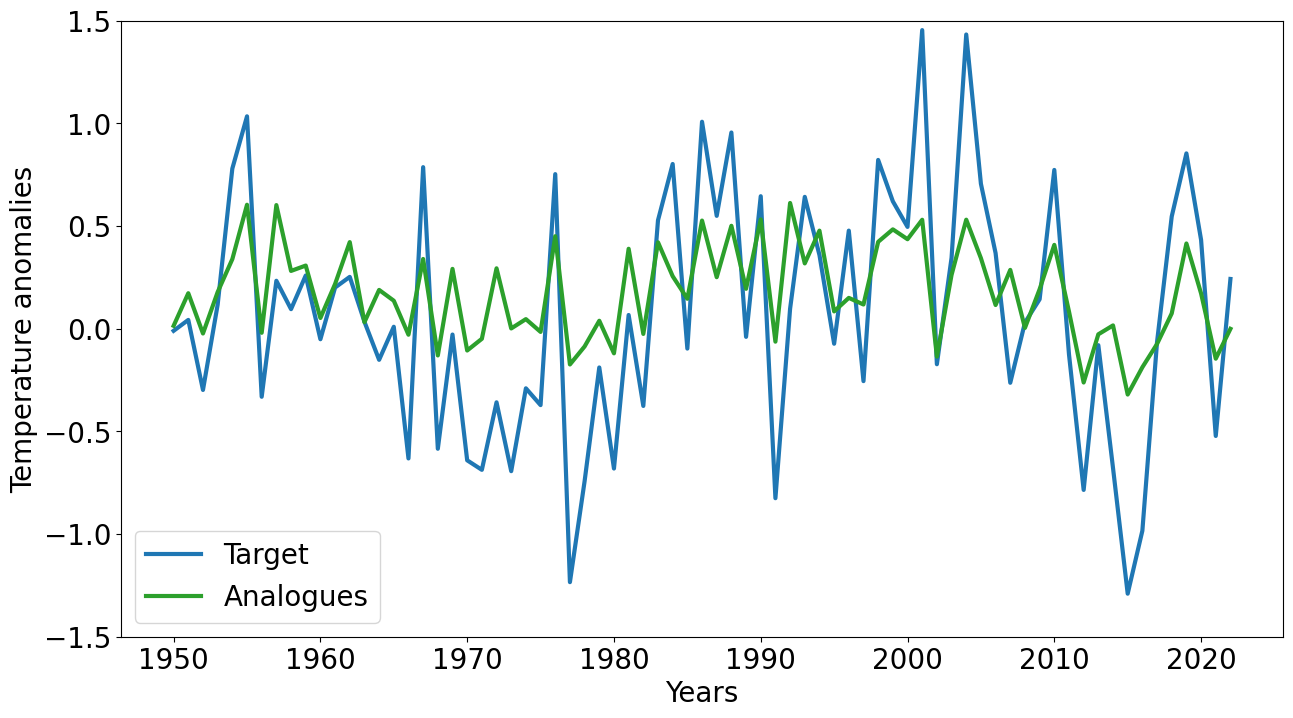

In [36]:
years = [i for i in range(1950, 2023)]
plt.figure(figsize=(15,8))
plt.plot(years,Ttarget_year[:,id_lat,id_lon],label='Target',linewidth=3)
plt.plot(years,Trec_analogues_year[:,id_lat,id_lon],label=f'Analogues',color='tab:green',linewidth=3)
plt.xlabel('Years', fontsize=20)
plt.ylabel('Temperature anomalies', fontsize=20)
plt.ylim(-1.5,1.5)
plt.legend(fontsize=20,loc='lower left')
plt.xticks(fontsize=20)  
plt.yticks(fontsize=20)

In [37]:
rmse_year_analogues = [[0 for i in range(32)] for j in range(32)]
corr_year_analogues = [[0 for i in range(32)] for j in range(32)]
v_year_analogues = [[0 for i in range(32)] for j in range(32)]

for i in range(32):
    for j in range(32):
        rmse_year_analogues[i][j]=rmse(Ttarget_year[:,i,j],Trec_analogues_year[:,i,j])
        corr_year_analogues[i][j]=np.corrcoef(Ttarget_year[:,i,j],Trec_analogues_year[:,i,j])[0,1]
        v_year_analogues[i][j]=float(np.var(Trec_analogues_year[:,i,j]))/float(np.var(Ttarget_year[:,i,j]))

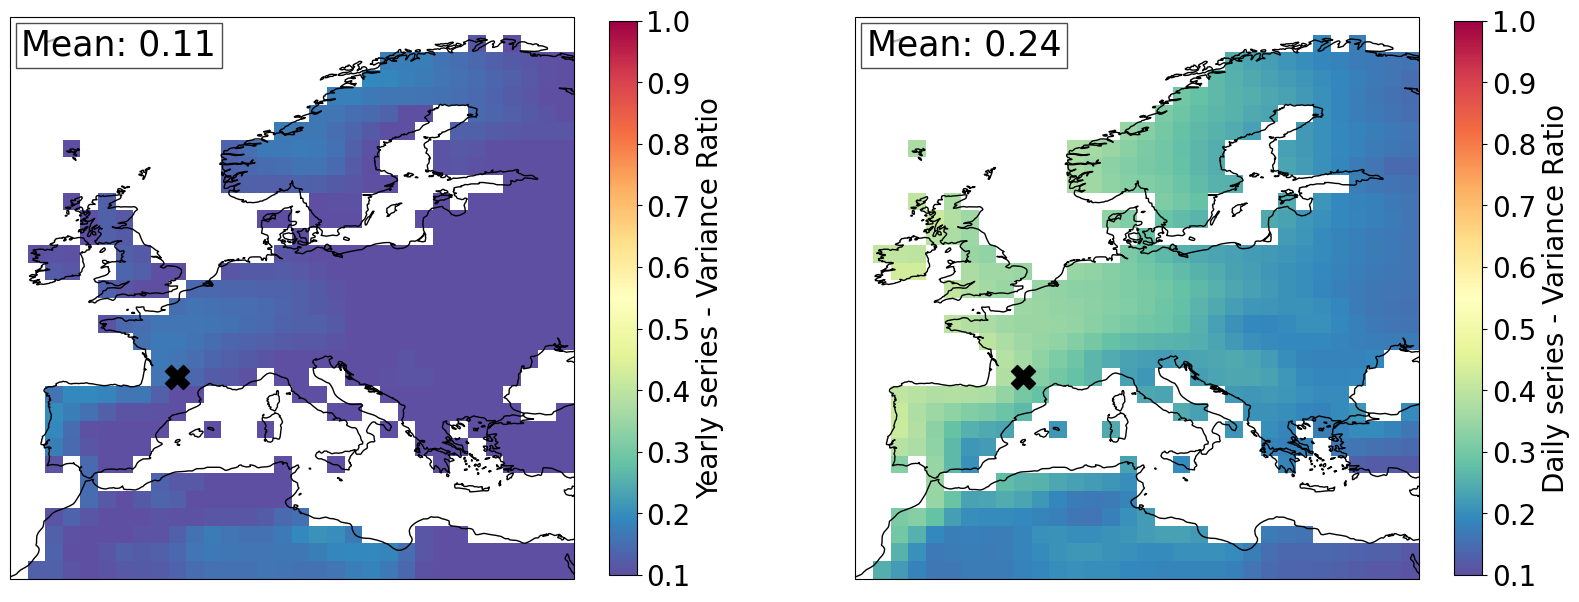

In [38]:
#VARIANCES

# Masquer les valeurs sur la mer
masked_v_year = np.ma.masked_where(masque == 1, v_year_analogues)
masked_v_day = np.ma.masked_where(masque == 1, v_day_ana)

# Code original avec les valeurs sur la mer masquées
fig, axs = plt.subplots(1, 2, figsize=(20, 12), subplot_kw={'projection': ccrs.PlateCarree()})

# Première carte
cf1 = axs[0].pcolormesh(lon, lat, masked_v_year,vmin=0.1,vmax=1,cmap=my_colormap, transform=ccrs.PlateCarree(0))
axs[0].coastlines()
axs[0].scatter(1.406,44.12, color='black', marker='X', s=300)
axs[0].text(0.02, 0.98, f'Mean: {masked_v_year.mean():.2f}', transform=axs[0].transAxes,
            fontsize=25, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))


# Deuxième carte
cf2 = axs[1].pcolormesh(lon, lat, masked_v_day,vmin=0.1,vmax=1, cmap=my_colormap, transform=ccrs.PlateCarree())
axs[1].coastlines()
axs[1].scatter(1.406,44.12, color='black', marker='X', s=300)
axs[1].text(0.02, 0.98, f'Mean: {masked_v_day.mean():.2f}', transform=axs[1].transAxes,
            fontsize=25, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))

cb1 = fig.colorbar(cf1, ax=axs[0], orientation='vertical', aspect=20, shrink=0.6)
cb2 = fig.colorbar(cf2, ax=axs[1], orientation='vertical', aspect=20, shrink=0.6)

cb1.ax.tick_params(labelsize=20)
cb2.ax.tick_params(labelsize=20)

cb1.set_label('Yearly series - Variance Ratio', fontsize=20)
cb2.set_label('Daily series - Variance Ratio', fontsize=20)

plt.show()


## Seasons

In [41]:
jours = Ttarget_r5['time'].dt.month
DJF_indices = np.where((jours == 1) | (jours == 2) | (jours == 12))[0] #index of DJF days
MAM_indices = np.where((jours == 3) | (jours == 4) | (jours == 5))[0] #index of MAM days
JJA_indices = np.where((jours == 6) | (jours == 7) | (jours == 8))[0] #index of JJA days
SON_indices = np.where((jours == 9) | (jours == 10) | (jours == 11))[0] #index of SON days

In [63]:
#transform numpy to DataArray
DJF_DataArray_unet = xr.DataArray(
   Trec_r5_unet[DJF_indices],
    coords={
        "time": Ttarget_r5["time"][DJF_indices], 
        "lat": Ttarget_r5.lat.values,
        "lon": Ttarget_r5.lon.values,
    },
    dims=["time", "lat", "lon"] )

JJA_DataArray_unet = xr.DataArray(
    Trec_r5_unet[JJA_indices],
    coords={
        "time": Ttarget_r5["time"][JJA_indices], 
        "lat": Ttarget_r5.lat.values,
        "lon": Ttarget_r5.lon.values,
    },
    dims=["time", "lat", "lon"] )

DJF_DataArray_ana = xr.DataArray(
    Trec_r5_analogues[DJF_indices],
    coords={  
        "time": Ttarget_r5["time"][DJF_indices], 
        "lat": Ttarget_r5.lat.values,
        "lon": Ttarget_r5.lon.values,
    },
    dims=["time", "lat", "lon"] )

JJA_DataArray_ana = xr.DataArray(
   Trec_r5_analogues[JJA_indices], 
    coords={
        "time": Ttarget_r5["time"][JJA_indices], 
        "lat": Ttarget_r5.lat.values,
        "lon": Ttarget_r5.lon.values,
    },
    dims=["time", "lat", "lon"] )

In [64]:
DJF_Ttarget_r5 = Ttarget_r5[DJF_indices]
JJA_Ttarget_r5 = Ttarget_r5[JJA_indices]

In [70]:
#compute JJA and DJF means for true series
ds_jja_target = JJA_Ttarget_r5.sel(time=JJA_Ttarget_r5[:,:,:]['time.month'].isin([6,7,8]))
JJA_mean_target = ds_jja_target.resample(time='YS-JUN').mean("time")

ds_djf_target = DJF_Ttarget_r5.sel(time=DJF_Ttarget_r5[:,:,:]['time.month'].isin([12,1,2]))
DJF_mean_target = ds_djf_target.resample(time='YS-JUN').mean("time")

In [71]:
#compute JJA and DJF means for unet reconstructions
ds_jja_unet = JJA_DataArray_unet.sel(time=JJA_DataArray_unet[:,:,:]['time.month'].isin([6,7,8]))
JJA_mean_unet = ds_jja_unet.resample(time='YS-JUN').mean("time")

ds_djf_unet = DJF_DataArray_unet.sel(time=DJF_DataArray_unet[:,:,:]['time.month'].isin([12,1,2]))
DJF_mean_unet = ds_djf_unet.resample(time='YS-JUN').mean("time")

In [72]:
#compute JJA and DJF means for analogues reconstructions
ds_jja_ana = JJA_DataArray_ana.sel(time=JJA_DataArray_ana[:,:,:]['time.month'].isin([6,7,8]))
JJA_mean_ana = ds_jja_ana.resample(time='YS-JUN').mean("time")

ds_djf_ana = DJF_DataArray_ana.sel(time=DJF_DataArray_ana[:,:,:]['time.month'].isin([12,1,2]))
DJF_mean_ana = ds_djf_ana.resample(time='YS-JUN').mean("time")

In [84]:
#compute scores for DJF unet
rmse_DJF_unet = [[0 for i in range(32)] for j in range(32)]
corr_DJF_unet = [[0 for i in range(32)] for j in range(32)]
v_DJF_unet = [[0 for i in range(32)] for j in range(32)]

for i in range(32):
    for j in range(32):
        rmse_DJF_unet[i][j]=rmse(DJF_mean_unet[:,i,j],DJF_mean_target[:,i,j])
        corr_DJF_unet[i][j]=np.corrcoef(DJF_mean_unet[:,i,j],DJF_mean_target[:,i,j])[0,1]
        v_DJF_unet[i][j]=float(np.var(DJF_mean_unet[:,i,j]))/float(np.var(DJF_mean_target[:,i,j]))

#compute scores for JJA unet
rmse_JJA_unet = [[0 for i in range(32)] for j in range(32)]
corr_JJA_unet = [[0 for i in range(32)] for j in range(32)]
v_JJA_unet = [[0 for i in range(32)] for j in range(32)]

for i in range(32):
    for j in range(32):
        rmse_JJA_unet[i][j]=rmse(JJA_mean_unet[:,i,j],JJA_mean_target[:,i,j])
        corr_JJA_unet[i][j]=np.corrcoef(JJA_mean_unet[:,i,j],JJA_mean_target[:,i,j])[0,1]
        v_JJA_unet[i][j]=float(np.var(JJA_mean_unet[:,i,j]))/float(np.var(JJA_mean_target[:,i,j]))

In [85]:
#Compute scores for DJF analogues
rmse_DJF_ana = [[0 for i in range(32)] for j in range(32)]
corr_DJF_ana = [[0 for i in range(32)] for j in range(32)]
v_DJF_ana = [[0 for i in range(32)] for j in range(32)]

for i in range(32):
    for j in range(32):
        rmse_DJF_ana[i][j]=rmse(DJF_mean_ana[:,i,j],DJF_mean_target[:,i,j])
        corr_DJF_ana[i][j]=np.corrcoef(DJF_mean_ana[:,i,j],DJF_mean_target[:,i,j])[0,1]
        v_DJF_ana[i][j]=float(np.var(DJF_mean_ana[:,i,j]))/float(np.var(DJF_mean_target[:,i,j]))

#Compute scores for JJA analogues
rmse_JJA_ana = [[0 for i in range(32)] for j in range(32)]
corr_JJA_ana = [[0 for i in range(32)] for j in range(32)]
v_JJA_ana = [[0 for i in range(32)] for j in range(32)]

for i in range(32):
    for j in range(32):
        rmse_JJA_ana[i][j]=rmse(JJA_mean_ana[:,i,j],JJA_mean_target[:,i,j])
        corr_JJA_ana[i][j]=np.corrcoef(JJA_mean_ana[:,i,j],JJA_mean_target[:,i,j])[0,1]
        v_JJA_ana[i][j]=float(np.var(JJA_mean_ana[:,i,j]))/float(np.var(JJA_mean_target[:,i,j]))

(array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.]),
 [Text(0, -4.0, '−4'),
  Text(0, -3.0, '−3'),
  Text(0, -2.0, '−2'),
  Text(0, -1.0, '−1'),
  Text(0, 0.0, '0'),
  Text(0, 1.0, '1'),
  Text(0, 2.0, '2'),
  Text(0, 3.0, '3'),
  Text(0, 4.0, '4')])

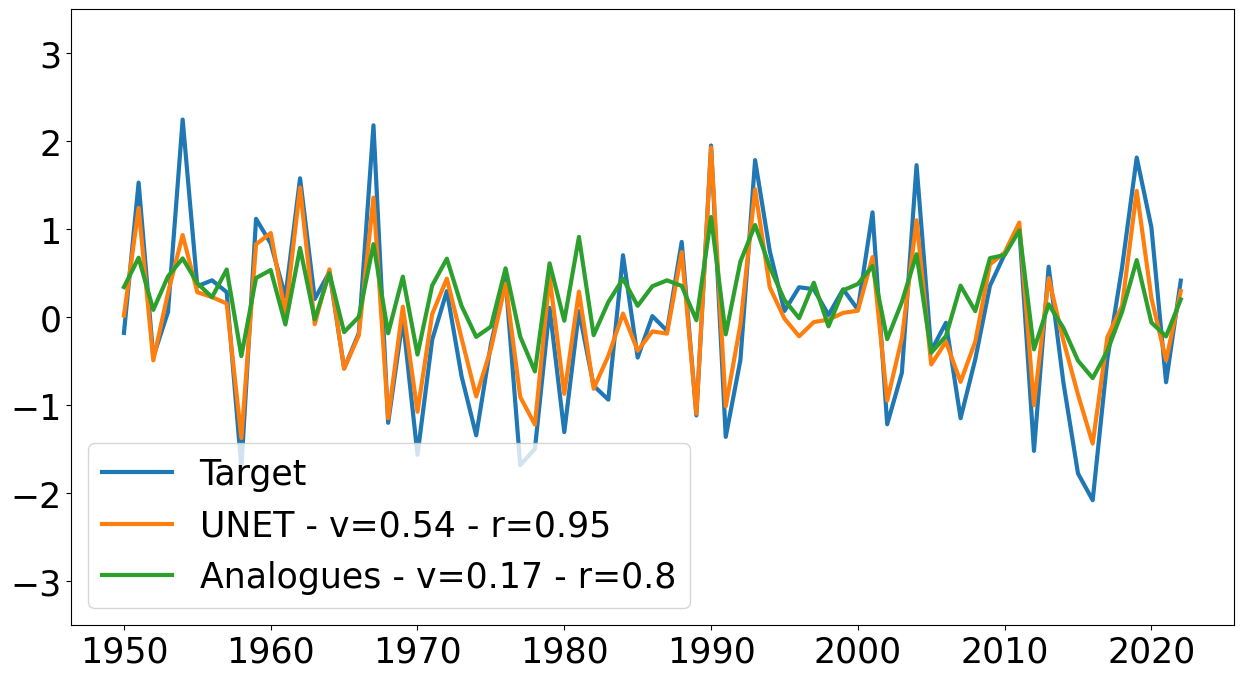

In [87]:
#plot JJA means
years = [i for i in range(1950, 2023)]
plt.figure(figsize=(15,8))
plt.plot(years,JJA_mean_target[:,id_lat,id_lon],label='Target',linewidth=3)
plt.plot(years,JJA_mean_unet[:,id_lat,id_lon],label=f'UNET - v={round(float(np.var(JJA_mean_unet[:,id_lat,id_lon]))/float(np.var(JJA_mean_target[:,id_lat,id_lon])),2)} - r={round(np.corrcoef(JJA_mean_unet[:,id_lat,id_lon],JJA_mean_target[:,id_lat,id_lon])[0][1],2)}',linewidth=3)
plt.plot(years,JJA_mean_ana[:,id_lat,id_lon],label=f'Analogues - v={round(float(np.var(JJA_mean_ana[:,id_lat,id_lon]))/float(np.var(JJA_mean_target[:,id_lat,id_lon])),2)} - r={round(np.corrcoef(JJA_mean_ana[:,id_lat,id_lon],JJA_mean_target[:,id_lat,id_lon])[0][1],2)}',linewidth=3)
plt.legend(loc='lower left')
y_limits=(-3.5,3.5)
plt.ylim(y_limits)
plt.legend(fontsize=25,loc='lower left')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

(array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.]),
 [Text(0, -4.0, '−4'),
  Text(0, -3.0, '−3'),
  Text(0, -2.0, '−2'),
  Text(0, -1.0, '−1'),
  Text(0, 0.0, '0'),
  Text(0, 1.0, '1'),
  Text(0, 2.0, '2'),
  Text(0, 3.0, '3'),
  Text(0, 4.0, '4')])

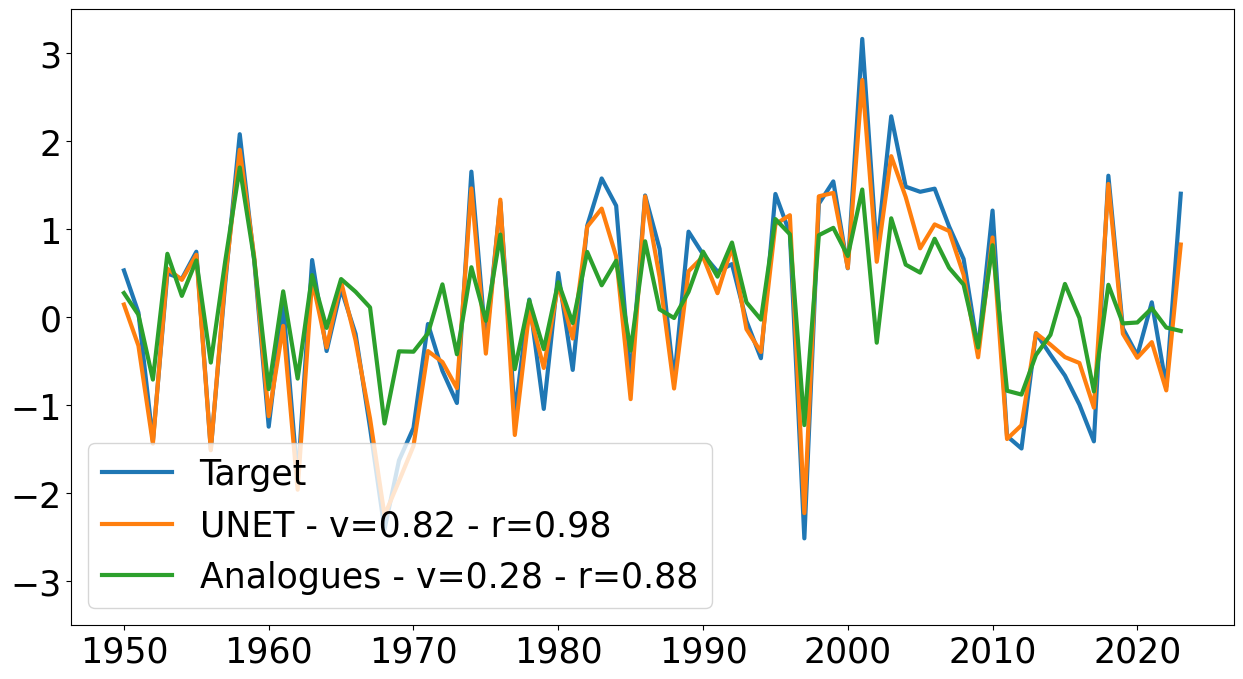

In [100]:
#plot DJF means
years = [i for i in range(1950, 2024)]
plt.figure(figsize=(15,8))
plt.plot(years,DJF_mean_target[:,id_lat,id_lon],label='Target',linewidth=3)
plt.plot(years,DJF_mean_unet[:,id_lat,id_lon],label=f'UNET - v={round(float(np.var(DJF_mean_unet[:,id_lat,id_lon]))/float(np.var(DJF_mean_target[:,id_lat,id_lon])),2)} - r={round(np.corrcoef(DJF_mean_unet[:,id_lat,id_lon],DJF_mean_target[:,id_lat,id_lon])[0][1],2)}',linewidth=3)
plt.plot(years,DJF_mean_ana[:,id_lat,id_lon],label=f'Analogues - v={round(float(np.var(DJF_mean_ana[:,id_lat,id_lon]))/float(np.var(DJF_mean_target[:,id_lat,id_lon])),2)} - r={round(np.corrcoef(DJF_mean_ana[:,id_lat,id_lon],DJF_mean_target[:,id_lat,id_lon])[0][1],2)}',linewidth=3)
plt.legend(loc='lower left')
y_limits=(-3.5,3.5)
plt.ylim(y_limits)
plt.legend(fontsize=25,loc='lower left')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

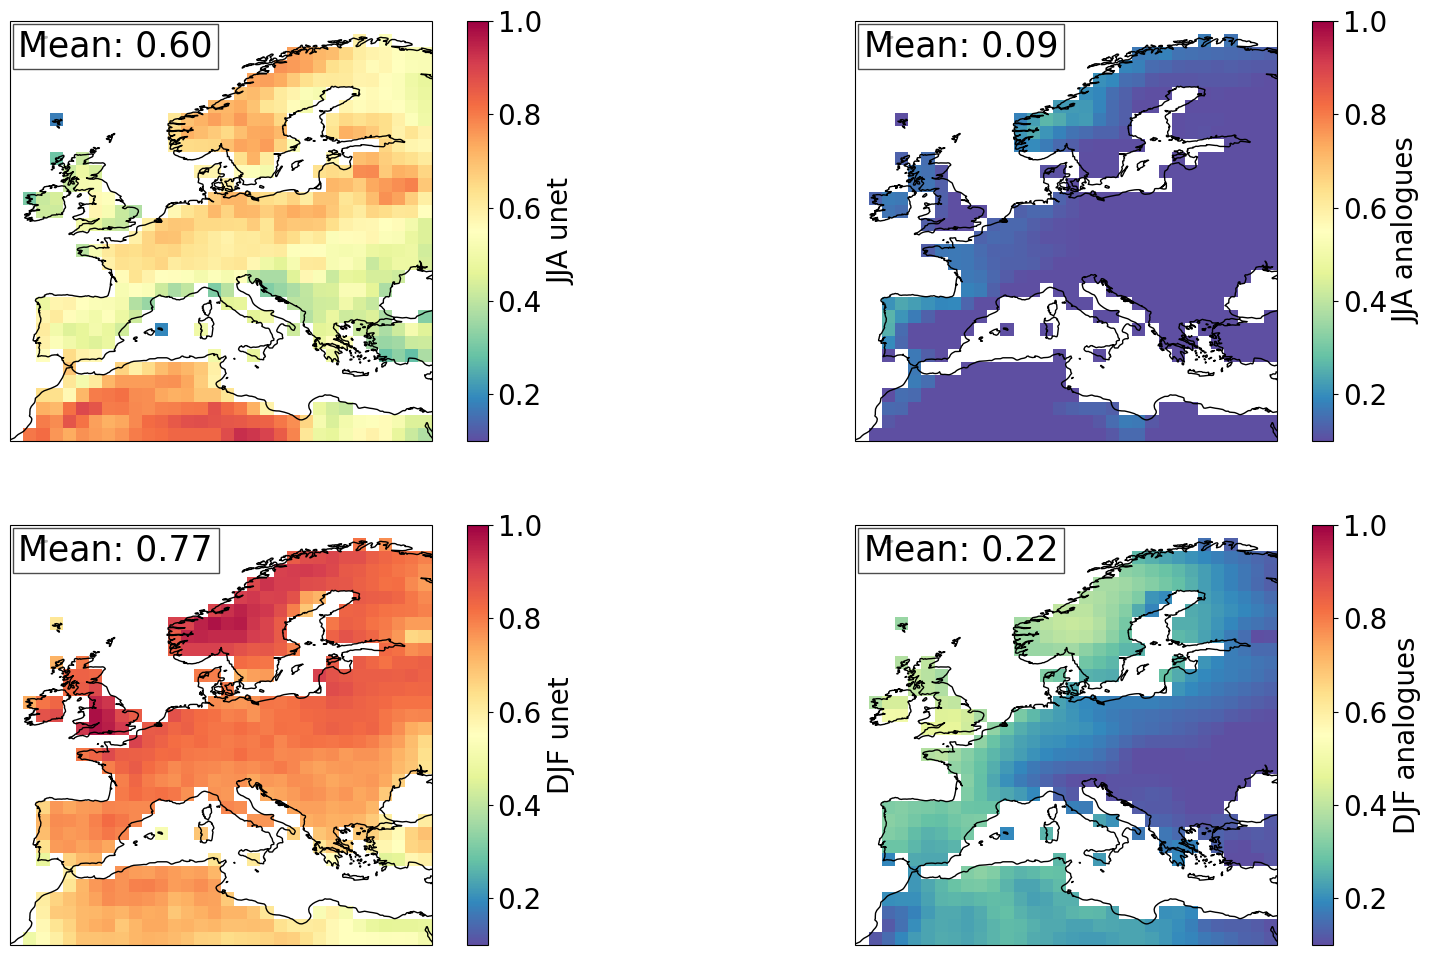

In [101]:
#plot variance ratio for seasons 
map1 = np.ma.masked_where(masque == 1, v_JJA_unet)
map2 = np.ma.masked_where(masque == 1, v_JJA_ana)
map3 = np.ma.masked_where(masque == 1, v_DJF_unet)
map4 = np.ma.masked_where(masque == 1, v_DJF_ana)

fig, axs = plt.subplots(2,2, figsize=(20, 12), subplot_kw={'projection': ccrs.PlateCarree()})

# map1 (JJA unet)
cf1 = axs[0,0].pcolormesh(lon, lat, map1,vmin=0.1,vmax=1,cmap=my_colormap, transform=ccrs.PlateCarree())
axs[0,0].coastlines()
axs[0,0].text(0.02, 0.98, f'Mean: {map1.mean():.2f}', transform=axs[0,0].transAxes,
            fontsize=25, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))

# map2 (JJA ana)
cf2 = axs[0,1].pcolormesh(lon, lat, map2, vmin=0.1,vmax=1,cmap=my_colormap, transform=ccrs.PlateCarree())
axs[0,1].coastlines()
axs[0,1].text(0.02, 0.98, f'Mean: {map2.mean():.2f}', transform=axs[0,1].transAxes,
            fontsize=25, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))

# map3 (DJF unet)
cf3 = axs[1,0].pcolormesh(lon, lat, map3, vmin=0.1,vmax=1,cmap=my_colormap, transform=ccrs.PlateCarree())
axs[1,0].coastlines()
axs[1,0].text(0.02, 0.98, f'Mean: {map3.mean():.2f}', transform=axs[1,0].transAxes,
            fontsize=25, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))

# map4 (DJF ana)
cf3 = axs[1,1].pcolormesh(lon, lat, map4, vmin=0.1,vmax=1,cmap=my_colormap, transform=ccrs.PlateCarree())
axs[1,1].coastlines()
axs[1,1].text(0.02, 0.98, f'Mean: {map4.mean():.2f}', transform=axs[1,1].transAxes,
            fontsize=25, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))

            
cb1 = fig.colorbar(cf1, ax=axs[0,0], orientation='vertical', aspect=20, shrink=1)
cb2 = fig.colorbar(cf2, ax=axs[0,1], orientation='vertical', aspect=20, shrink=1)
cb3 = fig.colorbar(cf3, ax=axs[1,0], orientation='vertical', aspect=20, shrink=1)
cb4 = fig.colorbar(cf3, ax=axs[1,1], orientation='vertical', aspect=20, shrink=1)

cb1.ax.tick_params(labelsize=20)
cb2.ax.tick_params(labelsize=20)
cb3.ax.tick_params(labelsize=20)
cb4.ax.tick_params(labelsize=20)

cb1.set_label('JJA unet', fontsize=20)
cb2.set_label('JJA analogues', fontsize=20)
cb3.set_label('DJF unet', fontsize=20)
cb4.set_label('DJF analogues', fontsize=20)

plt.show()


## Figure 4

In [102]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from sklearn.preprocessing import OneHotEncoder
import keras

from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, Flatten, Dense, UpSampling2D, Conv2DTranspose,Conv3DTranspose, Reshape, concatenate, BatchNormalization, Activation
from tensorflow.keras.layers import Input,  LeakyReLU, Concatenate, Dropout, Conv1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, History
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split  


#### Seasons

In [103]:
m_season = load_model('/model_season') #load Neural network

In [105]:
slp_test = xr.open_dataset('/UNET-vs-Analogues_data/psl_day_MIROC6_unet_r5i1p1f1_CR.nc').psl[10950:] #load test slp data

In [106]:
#TRUE SEASONS
season = []

for i in range(len(slp_test)):
    if int(str(slp_test.time.values[i])[5:7]) == 1 or int(str(slp_test.time.values[i])[5:7]) == 2 or int(str(slp_test.time.values[i])[5:7]) == 12:
        #if DJF, season=1 
        season.append(1)
    if int(str(slp_test.time.values[i])[5:7]) == 3 or int(str(slp_test.time.values[i])[5:7]) == 4 or int(str(slp_test.time.values[i])[5:7]) == 5:
        #if MAM, season=2
        season.append(2)
    if int(str(slp_test.time.values[i])[5:7]) == 6 or int(str(slp_test.time.values[i])[5:7]) == 7 or int(str(slp_test.time.values[i])[5:7]) ==8:
        #if JJA, season=3
        season.append(3)
    if int(str(slp_test.time.values[i])[5:7]) == 9 or int(str(slp_test.time.values[i])[5:7]) == 10 or int(str(slp_test.time.values[i])[5:7]) == 11:
        #if SON, season=4
        season.append(4)
        
enc=OneHotEncoder() #we use OneHotEncoder to encode the seasons
target_season = np.array(season).reshape(-1, 1)
target_season_ohe = enc.fit_transform(target_season)
target_season_ohe = target_season_ohe.toarray()

In [107]:
#PREDICTED SEASONS
season_predicted = m_season.predict(slp_test) #test the model on spl data

2521/2521 [==============================] - 118s 47ms/step


In [108]:
target_class_season = np.argmax(target_season_ohe, axis=1) #true season
prediction_class_season = np.argmax(season_predicted,axis=1) #predicted season

Text(20.72222222222222, 0.5, 'Saisons prédites')

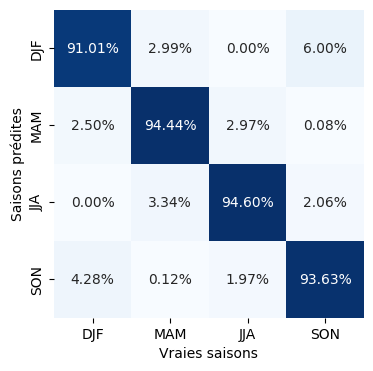

In [109]:
cm = confusion_matrix(prediction_class_season, target_class_season, normalize='true')

plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues', xticklabels=['DJF', 'MAM', 'JJA', 'SON'], yticklabels=['DJF', 'MAM', 'JJA', 'SON'], annot_kws={"size": 10}, cbar=False)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)
plt.xlabel('Vraies saisons', fontsize=10)
plt.ylabel('Saisons prédites', fontsize=10)

### Day

In [110]:
m_day = load_model('/model_day') #load Neural network

In [112]:
slp_test = xr.open_dataset('/UNET-vs-Analogues_data/psl_day_MIROC6_unet_r5i1p1f1_CR.nc').psl[10950:] #load test slp data

In [68]:
day_predicted = m_day.predict(slp_test) #test the model on slp

2521/2521 [==============================] - 93s 37ms/step


In [73]:
cos_pred = day_predicted[:,0] #predicted cos
sin_pred = day_predicted[:,1] #predicted sin

arct_pred = []
for i in range(len(cos_pred)):
    arct_pred.append(math.atan2(sin_pred[i], cos_pred[i]))
    
pred_days=[]
for i in arct_pred:
    pred_days.append(((365*i)/(2*math.pi))%365)

In [70]:
true_days = [i for i in range(365)]*221

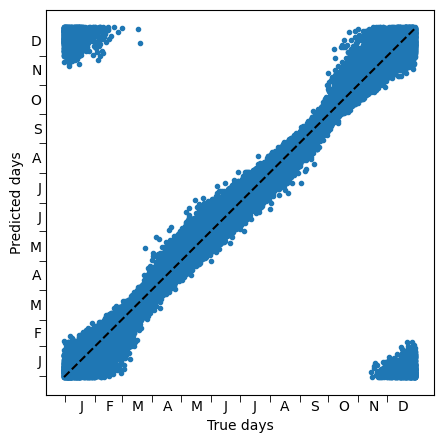

In [74]:
plt.figure(figsize=(5,5))
plt.plot(true_days,pred_days,'.')
plt.plot([0, 365], [0, 365], '--', color='black', label='y=x')
x_ticks_positions = [18,47,76,107,137,168,198,229,260,290,321,351]
visible_ticks_positions = [1,32,60,91,121,152,182,213,244,274,305,335]
x_ticks_labels = ['J', 'F', 'M', 'A', 'M', 'J','J','A','S','O','N','D']

plt.xlabel('True days',fontsize=10)
plt.ylabel('Predicted days',fontsize=10)
plt.xticks(ticks=x_ticks_positions, labels=x_ticks_labels, fontsize=10)
plt.yticks(ticks=x_ticks_positions, labels=x_ticks_labels, fontsize=10)

plt.tick_params(axis='both', which='major', length=0)
plt.gca().set_xticks(visible_ticks_positions, minor=True)
plt.gca().set_yticks(visible_ticks_positions, minor=True)
plt.tick_params(axis='both', which='minor', length=5, color='black')

plt.show()

### Year

In [113]:
m_year = load_model('/model_year') #load Neural network

In [114]:
slp_test = xr.open_dataset('/UNET-vs-Analogues_data/psl_day_MIROC6_unet_r5i1p1f1_CR.nc').psl[10950:] #load test slp data

In [77]:
# Year prediction
year_predicted = m_year.predict(slp_test) #test the model on slp

2521/2521 [==============================] - 95s 38ms/step


In [78]:
#True year

true_year =[]
for i in range(len(slp_test)):
    true_year.append(int(str(slp_test.time.values[i])[0:4]))
        
enc=OneHotEncoder()
target_annee = np.array(true_year).reshape(-1, 1)
target_annee_ohe = enc.fit_transform(target_annee)
target_annee_ohe = target_annee_ohe.toarray()

In [80]:
prediction_class_year = np.argmax(year_predicted,axis=1)
target_class_year = np.argmax(target_annee_ohe, axis=1)

Text(0, 0.5, 'Predicted years')

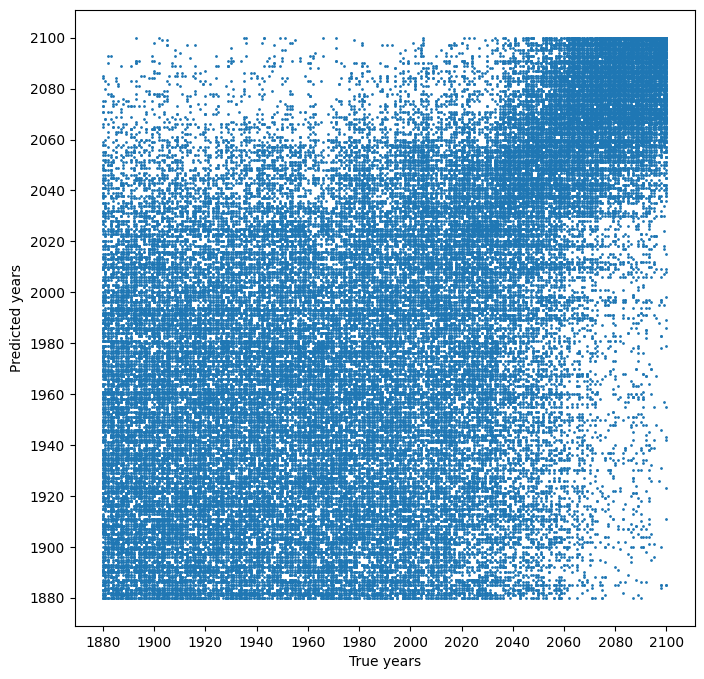

In [81]:
plt.figure(figsize=(8,8))
plt.plot(target_class_year,prediction_class_year,'.',markersize=2)
month_labels = [str(i) for i in range(1880,2120,20)]
plt.xticks([i for i in range(0,221,20)], labels=month_labels,fontsize=10)
plt.yticks([i for i in range(0,221,20)], labels=month_labels,fontsize=10)
plt.xlabel('True years',fontsize=10)
plt.ylabel('Predicted years',fontsize=10)